In [1]:
!pip install --force-reinstall agent_system/dist/mesa_restaurant_agents-0.0.1-py3-none-any.whl

Processing ./agent_system/dist/mesa_restaurant_agents-0.0.1-py3-none-any.whl
  Using cached mesa-3.1.0-py3-none-any.whl.metadata (9.9 kB)
  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached numpy-2.2.2-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached scipy-1.15.1-cp312-cp312-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-macosx_10_13_universal2.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Usin

In [2]:
import mesa
from mesa_restaurant_agents.model.restaurant_model import RestaurantModel

params = {"n_waiters":2, "grid_width":50, "grid_height": 50}

results = mesa.batch_run(
    RestaurantModel,
    parameters=params,
    iterations=5,
    max_steps=10,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)
print(results)

  0%|          | 0/5 [00:00<?, ?it/s]

[{'RunId': 0, 'iteration': 0, 'Step': 0, 'n_waiters': 2, 'grid_width': 50, 'grid_height': 50, 'Customer_Count': 3, 'Average_Wait_Time': np.float64(0.0), 'Average_Customer_Satisfaction': np.float64(100.0), 'Profit': np.float64(0.0), 'Customer_Info': [{'customer_nr': 0, 'waiting_time': 0, 'order_status': 0, 'satisfaction': 100}, {'customer_nr': 1, 'waiting_time': 0, 'order_status': 0, 'satisfaction': 100}, {'customer_nr': 2, 'waiting_time': 0, 'order_status': 0, 'satisfaction': 100}]}, {'RunId': 0, 'iteration': 0, 'Step': 1, 'n_waiters': 2, 'grid_width': 50, 'grid_height': 50, 'Customer_Count': 3, 'Average_Wait_Time': np.float64(0.0), 'Average_Customer_Satisfaction': np.float64(100.0), 'Profit': np.float64(0.0), 'Customer_Info': [{'customer_nr': 0, 'waiting_time': 0.0, 'order_status': 1, 'satisfaction': 100.0}, {'customer_nr': 1, 'waiting_time': 0.0, 'order_status': 0, 'satisfaction': 100.0}, {'customer_nr': 2, 'waiting_time': 0.0, 'order_status': 0, 'satisfaction': 100.0}]}, {'RunId': 0

/opt/anaconda3/envs/mesa_tutorial/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/mesa_tutorial/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Text(0.5, 1.0, 'Visualization of agents in grid')]

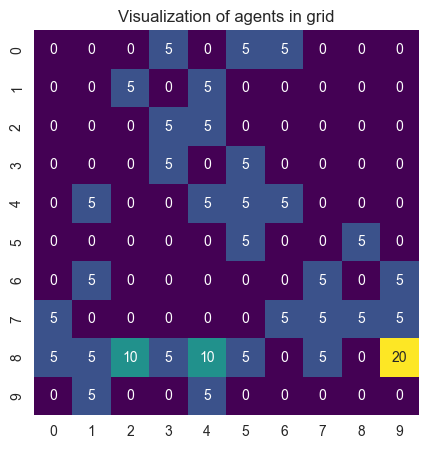

In [3]:
import seaborn as sns
import numpy as np
from mesa_restaurant_agents.agents.customer_agent import CustomerAgent
from mesa_restaurant_agents.agents.manager_agent import ManagerAgent
from mesa_restaurant_agents.agents.waiter_agent import WaiterAgent

model = RestaurantModel(n_waiters=2, grid_width=10, grid_height=10)
for i in range(10):
    model.step()

agents_position = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    if len(cell_content) > 0:
        if isinstance(cell_content[0], CustomerAgent):
            agents_position[x][y] = 5
        elif isinstance(cell_content[0], WaiterAgent):
            agents_position[x][y] = 10
        else:
            agents_position[x][y] = 20
    else:
        agents_position[x][y] = 0
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agents_position, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="Visualization of agents in grid")

In [4]:
from mesa_restaurant_agents.visualization import *

df_mean_step = display_mean_step_results(results)
df_first_run = display_first_run_step_results(results)

ModuleNotFoundError: No module named 'plotly'

In [4]:
df_mean_step

,Step,mean_customer_count,mean_waiting_time,mean_customer_satisfaction,mean_profit
0,0,2.6,0.000000,100.000000,0.0
1,1,4.0,0.000000,100.000000,0.0
2,2,5.4,1.728571,96.542857,0.0
3,3,8.0,3.021429,93.957143,0.0
4,4,9.2,4.904040,90.191919,0.0
5,5,10.4,7.872222,84.255556,0.0
6,6,11.8,10.620513,78.758974,0.0
7,7,13.8,12.415385,75.169231,0.0
8,8,16.0,14.237745,71.524510,0.0
9,9,17.4,16.795527,66.408947,0.0


In [5]:
df_first_run.sort_values(['customer_nr', 'step'])

,customer_nr,waiting_time,order_status,satisfaction,step
0,0,0.0,0,100.0,2
2,0,0.0,1,100.0,3
7,0,0.0,3,100.0,4
13,0,0.0,3,100.0,5
21,0,0.0,3,100.0,6
...,...,...,...,...,...
77,16,0.0,0,100.0,9
95,16,5.0,0,90.0,10
78,17,0.0,0,100.0,9
96,17,0.0,0,100.0,10
